# NASA Earthdata Worldview

https://worldview.earthdata.nasa.gov/?p=geographic&l=SMAP_L4_Emult_Average&t=2018-08-01-T00%3A00%3A00Z&z=3&v=-180,-90,180,90

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
from PIL import Image
import pandas as pd
from imageio import mimwrite
import requests

In [44]:
def collect_img_binary(date, layer, extent, width, height):
    
    # Create URL to download image
    nasa_url = "https://wvs.earthdata.nasa.gov/api/v1/snapshot?REQUEST=GetSnapshot"
    nasa_url += "&TIME=%s" % date.strftime('%Y-%m-%d')
    nasa_url += "&BBOX=%s" % ','.join([str(e) for e in extent])
    nasa_url += "&CRS=EPSG:4326"
    nasa_url += "&LAYERS=%s" % layer
    nasa_url += "&FORMAT=image/png"
    nasa_url += "&WIDTH={0:d}&HEIGHT={1:d}".format(width, height)
    
    # Request content and save binary PNG file in variable
    r = requests.get(nasa_url, allow_redirects=True)
    img_binary = r.content
    
    return img_binary

In [45]:
def recreate_img(img_binary, height):
    
    # Store binary content in PNG file 'temp.png'
    with open('temp.png', 'wb') as f:
        f.write(img_binary)

    # Open PNG file and extract data value for each RGBA pixel
    im_frame = Image.open('temp.png')
    data = np.array(im_frame.getdata()).reshape(height, -1, 4)
    
    return data

In [46]:
def collect_dataset(start_date, end_date, layer, extent=(27, -10, 63, 43),
                    width=400, frequency='1MS'):
    
    # Compute height based on width and the bounding box of the image
    relation = float(extent[2] - extent[0]) / (extent[3] - extent[1])
    height = int(width * relation)
    
    timeline = pd.date_range(start_date, end_date, freq=frequency)
    
    dataset = []
    
    for t in timeline:
        
        img_binary = collect_img_binary(t.date(), layer, extent, width, height)
    
        data = recreate_img(img_binary, height)

        data = data[..., :3].astype('uint8')

        dataset.append(data)

        print(t.strftime('%Y-%m-%d'))
    
    return np.array(dataset)

In [47]:
def img_has_content(data, thresh=0.15):
    rows_with_content = np.where(np.sum(data, axis=(-2, -1)))
    return np.max(rows_with_content) > data.shape[1]*thresh

# Test functions

In [83]:
layer = 'VIIRS_SNPP_CorrectedReflectance_TrueColor'

In [84]:
start_date = '2018-01-01'
end_date = '2018-12-31'

In [85]:
extent=(-80, -160, 80, 180)
width=1280
frequency='12MS'

In [86]:
dataset = collect_dataset(start_date, end_date, layer,
                          extent, width, frequency='12MS')

2018-01-01


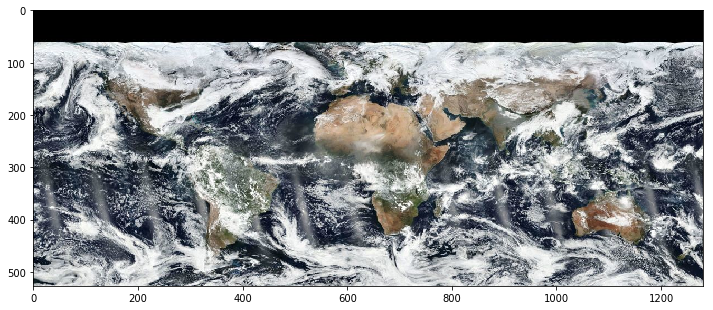

In [87]:
plt.figure(figsize=(12, 10))
plt.imshow(dataset[0]);

In [66]:
layers=['MODIS_Aqua_Chlorophyll_A',
        'MODIS_Combined_Thermal_Anomalies_All',
        'MODIS_Terra_Chlorophyll_A',
        'MODIS_Terra_EVI_8Day',
        'SMAP_L1_Passive_Enhanced_Brightness_Temp_Fore_H',
        'SMAP_L2_Passive_Enhanced_Day_Soil_Moisture_Option1',
        'SMAP_L4_Emult_Average',
        'SMAP_L4_Mean_Heterotrophic_Respiration',
        'SMAP_L4_Mean_Net_Ecosystem_Exchange',
        'SMAP_L4_Soil_Temperature_Layer_1',
        'SMAP_L4_Uncertainty_Mean_Net_Ecosystem_Exchange',
        'VIIRS_SNPP_CorrectedReflectance_TrueColor'
        ]

In [67]:
start_date = '2018-01-01'
end_date = '2018-12-31'

extent=(-60, -160, 80, 180)
width=1280
frequency='1MS'

for l in layers:
    print('\n', l)
    dataset = collect_dataset(start_date, end_date, l, extent, width, frequency)
    mimwrite('gif_%s.gif' % l, dataset, format='gif', fps=6)


 SMAP_L4_Emult_Average
2018-01-01

 MODIS_Terra_EVI_8Day
2018-01-01

 SMAP_L4_Soil_Temperature_Layer_1
2018-01-01

 SMAP_L2_Passive_Enhanced_Day_Soil_Moisture_Option1
2018-01-01

 SMAP_L4_Uncertainty_Mean_Net_Ecosystem_Exchange
2018-01-01

 SMAP_L4_Mean_Net_Ecosystem_Exchange
2018-01-01

 SMAP_L4_Mean_Heterotrophic_Respiration
2018-01-01

 MODIS_Combined_Thermal_Anomalies_All
2018-01-01

 MODIS_Terra_Chlorophyll_A
2018-01-01

 MODIS_Aqua_Chlorophyll_A
2018-01-01

 SMAP_L1_Passive_Enhanced_Brightness_Temp_Fore_H
2018-01-01

 VIIRS_SNPP_CorrectedReflectance_TrueColor
2018-01-01


In [68]:
start_date = '2018-01-01'
end_date = '2018-02-31'
width=400
frequency='1D'

In [69]:
layer = 'VIIRS_SNPP_CorrectedReflectance_TrueColor'
extent = (45.8,5.9,47.8,10.5)
dataset = collect_dataset(start_date, end_date, layer, extent, width, frequency)

2018-01-01
2018-01-22
2018-02-12
2018-03-05
2018-03-26
2018-04-16
2018-05-07
2018-05-28
2018-06-18
2018-07-09
2018-07-30


KeyboardInterrupt: 

In [ ]:
timeline = pd.date_range(start_date, end_date, freq='1W')
timeline.shape

In [ ]:
dataset.shape

In [ ]:
plt.imshow(np.min(dataset, axis=0)/255.)

In [ ]:
df = pd.DataFrame(dataset.reshape(dataset.shape[0], -1))
df.shape

In [ ]:
window_size = 16

In [ ]:
%time new = df.rolling(window_size).quantile(0.01)

In [ ]:
%time ok = new.to_numpy().reshape(dataset.shape).astype('uint8')

In [ ]:
plt.imshow(ok[200])

In [ ]:
#%time mimwrite('gif_orig.gif', dataset, format='gif', fps=30)

In [ ]:
%time mimwrite('gif_ok.gif', ok, format='gif', fps=12)